In [2]:
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.api as sm
%matplotlib inline

app_dir = '/Users/nikhilvs/repos/nyu/covid-19'

In [3]:
df = pd.read_csv(os.path.join(app_dir, 'data/staging/unified.csv'))
country_df = df[df['country_region'] == 'Spain']

In [4]:
list(df.columns)

['country_region',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing',
 'StringencyIndex',
 'cases',
 'cases_lag_1',
 'cases_lag_2',
 'cases_lag_3',
 'cases_lag_4',
 'cases_lag_5',
 'cases_lag_6',
 'cases_lag_7',
 'cases_lag_8',
 'cases_lag_9',
 'cases_lag_10',
 'cases_lag_11',
 'cases_lag_12',
 'cases_lag_13',
 'cases_lag_14',
 'cases_lag_15',
 'cases_lag_16',
 'cases_lag

In [5]:
TRAIN_COLUMNS = [
    # 'country_region',
    # 'date',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    'C5_Close public transport',
    'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    'E1_Income support',
    'E2_Debt/contract relief',
    'H1_Public information campaigns',
    'H2_Testing policy',
    'H3_Contact tracing',
    'StringencyIndex',
    'population_density',
    # 'cases_lag_1',
    # 'cases_lag_2',
    # 'cases_lag_3',
    # 'cases_lag_4',
    # 'cases_lag_5',
    # 'cases_lag_6',
    'cases_lag_7'
    # 'cases_lag_8',
    # 'cases_lag_9',
    # 'cases_lag_10'
    # 'date+1_pred',
    # 'date+2_pred',
    # 'date+3_pred',
    # 'date+4_pred',
    # 'date+5_pred',
    # 'date+6_pred',
    # 'date+7_pred',
    # 'date+8_pred',
    # 'date+1_linf',
    # 'date+2_linf',
    # 'date+3_linf',
    # 'date+4_linf',
    # 'date+5_linf',
    # 'date+6_linf',
    # 'date+7_linf',
    # 'date+8_linf',
    # 'date+1_lsup',
    # 'date+2_lsup',
    # 'date+3_lsup',
    # 'date+4_lsup',
    # 'date+5_lsup',
    # 'date+6_lsup',
    # 'date+7_lsup',
    # 'date+8_lsup'
]

TARGET_COLUMNS = [
    'cases'
]

COUNTRIES = [
    'United States', 
    'India', 
    'Italy', 
    'Canada', 
    'Spain', 
    'France', 
    'United Kingdom',
    'Iraq',
    'Japan',
    'South Korea',
    'Germany',
    'Brazil'
]

In [6]:
# for SHIFT_IMPACT_DAYS in list(range(1, 10)):
SHIFT_IMPACT_DAYS = 8
all_countries_df = None

for country in COUNTRIES:
    country_shifted_df = df[df['country_region'] == country].copy()

    SHIFT_COL_TARGET = 'cases_' + str(SHIFT_IMPACT_DAYS)
    country_shifted_df[SHIFT_COL_TARGET] = country_shifted_df['cases'].shift(-SHIFT_IMPACT_DAYS)

    for lag in range(1, 11):
        SHIFT_COL = f'cases_lag_{lag}_' + str(SHIFT_IMPACT_DAYS)
        country_shifted_df[SHIFT_COL] = country_shifted_df[f'cases_lag_{lag}'].shift(-SHIFT_IMPACT_DAYS)

    country_shifted_df = country_shifted_df.dropna()
    if all_countries_df is None:
        all_countries_df = pd.DataFrame(columns = country_shifted_df.columns)
    
    all_countries_df = all_countries_df.append(country_shifted_df)



In [27]:
# fit polynomial regressor

SIGNIFICANT_TRAIN_COLUMNS = TRAIN_COLUMNS.copy()
# SIGNIFICANT_TRAIN_COLUMNS.remove('grocery_and_pharmacy_percent_change_from_baseline')
# SIGNIFICANT_TRAIN_COLUMNS.remove('H3_Contact tracing')
# SIGNIFICANT_TRAIN_COLUMNS.remove('C8_International travel controls')
# SIGNIFICANT_TRAIN_COLUMNS.remove('population_density')
# SIGNIFICANT_TRAIN_COLUMNS.remove('C2_Workplace closing')
# SIGNIFICANT_TRAIN_COLUMNS.remove('residential_percent_change_from_baseline')

train_subset = all_countries_df[all_countries_df['date'] <= '2020-04-24']
test_subset = all_countries_df[all_countries_df['date'] > '2020-04-24']
val_subset = test_subset[test_subset['date'] <= '2020-04-30']
test_subset = test_subset[test_subset['date'] > '2020-04-30']

X_train = train_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_train = train_subset[SHIFT_COL_TARGET]
X_val = val_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_val = val_subset[SHIFT_COL_TARGET]
X_test = test_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_test = test_subset[SHIFT_COL_TARGET]

poly = PolynomialFeatures(3)

X_train_poly = poly.fit_transform(X_train)
scaler = preprocessing.StandardScaler().fit(X_train_poly)

X_train_poly = scaler.transform(X_train_poly)
X_val_poly = scaler.transform(poly.transform(X_val))
X_test_poly = scaler.transform(poly.transform(X_test))

# reg = LinearRegression().fit(X_train_poly, y_train)
# reg = Ridge(alpha = 10).fit(X_train_poly, y_train)
# print(reg.score(X_train_poly, y_train))
# test_pred = reg.predict(X_test_poly)
# print(mean_squared_error(y_test, test_pred))
# print(r2_score(y_test, test_pred))

# train_pred = reg.predict(X_train_poly)

L2_REGS = [0.1, 0.5, 0.75, 0.8, 0.82, 0.85, 0.87, 0.9, 0.93, 0.95, 1, 1.05, 2, 3, 3.5, 4, 4.5, 5, 6, 7, 10, 20]
# L2_REGS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 96, 97, 98, 100, 105, 110, 120]
VAL_MSES = []
VAL_R2 = []
for l2_reg in L2_REGS:
    reg = Ridge(alpha = l2_reg).fit(X_train_poly, y_train)
    val_pred = reg.predict(X_val_poly)
    val_mse = mean_squared_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    VAL_MSES.append(val_mse)
    VAL_R2.append(val_r2)


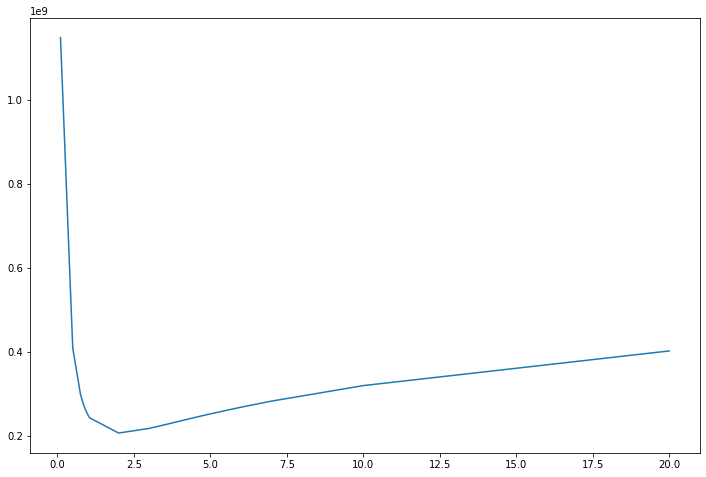

In [28]:
plt.figure(figsize = (12, 8))
# plt.plot(L2_REGS, VAL_MSES)
plt.plot(L2_REGS, VAL_MSES)

In [29]:
# significance testing

X_train_const = sm.add_constant(X_train_poly)
ols_regressor = sm.OLS(endog = y_train, exog = np.asarray(X_train_const)).fit()
ridge_regressor = sm.OLS(endog = y_train, exog = np.asarray(X_train_const)).fit_regularized(
    method = 'elastic_net',
    alpha = 10,
    L1_wt = 0
)

In [30]:
reg = Ridge(alpha = 3.5).fit(X_train_poly, y_train)
val_pred = reg.predict(X_val_poly)
val_mse = mean_squared_error(y_val, val_pred)
train_pred = reg.predict(X_train_poly)
val_pred = reg.predict(X_val_poly)

all_countries = train_subset['country_region'].append(val_subset['country_region'])
all_preds = np.append(train_pred, val_pred)
all_gt = y_train.append(y_val)

test_countries = test_subset['country_region']
countries_with_preds = pd.DataFrame(data = {
    'country' : all_countries,
    'preds' : all_preds,
    'gt': all_gt
})


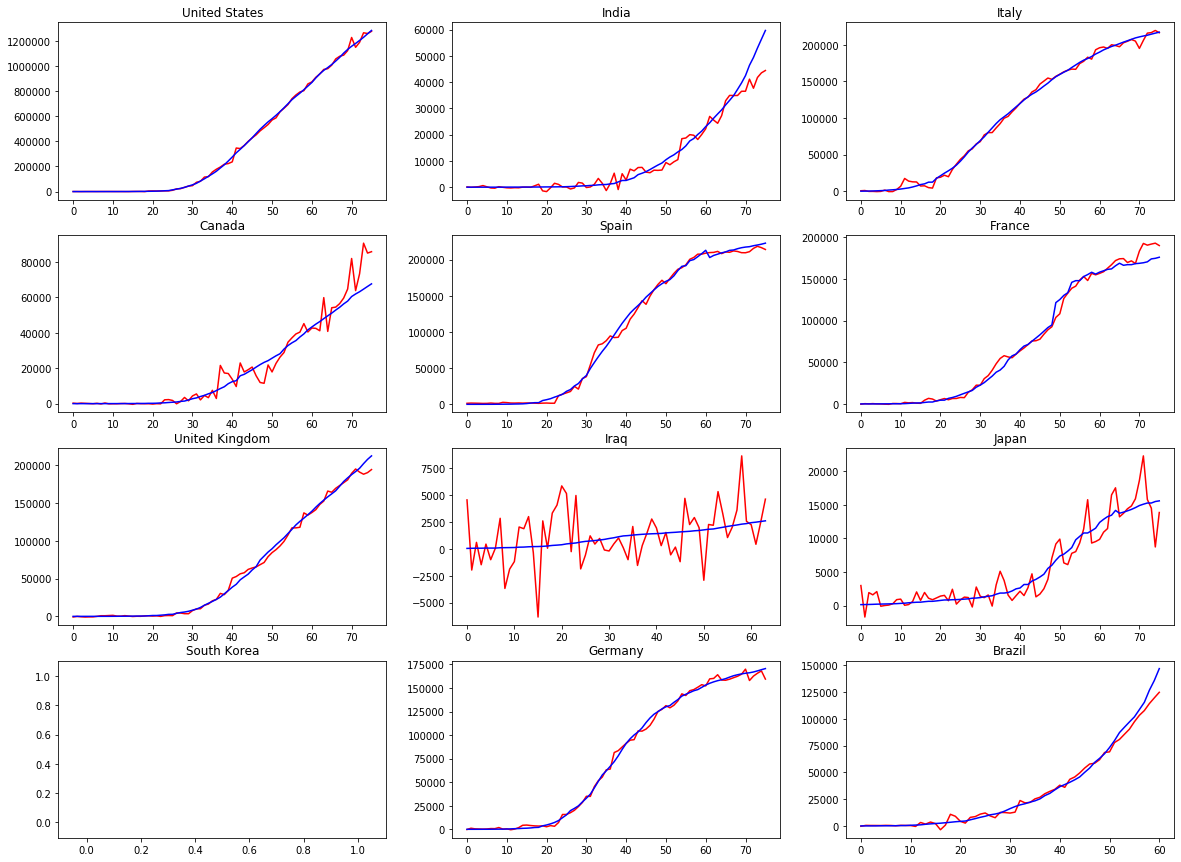

In [31]:
fig, (
    (ax11, ax12, ax13), 
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
    (ax41, ax42, ax43)
) = plt.subplots(4, 3)
# fig.suptitle('Sharing x per column, y per row')

fig.set_figwidth(20)
fig.set_figheight(15)
axes = [ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33, ax41, ax42, ax43]
countries = COUNTRIES

for country, ax in zip(countries, axes):
    country_preds = countries_with_preds[countries_with_preds['country'] == country]
    dates = np.arange(country_preds.shape[0])
    ax.plot(dates, country_preds['preds'], 'r-')
    ax.plot(dates, country_preds['gt'], 'b-')
    ax.set_title(country)